In [82]:
import os
from typing import Dict, NamedTuple, Union, List
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

In [12]:
class Config(NamedTuple):
    data_1: str = "../pre_vertical.csv"
    data_2: str = "../2way_anova_portrait.csv"
    dirctory: str = "../images/dataviz"
    savefile: bool = False
    kwarg_savefig: Dict[str, Union[str, int, float]] = {
        "facecolor": "white",
        "dpi": 300,
        "bbox_inches": "tight",
        "pad_inches": 0.05
    }

In [71]:
def power(
    data: pd.core.frame.DataFrame, 
    dim: int,
    subtract_scale: bool = True,
    name_digit: int = 3
    ) -> pd.core.frame.DataFrame:

    assert isinstance(dim, int) and dim >= 1, \
        f"dim expected non-zero positive int; got {dim}"
    assert isinstance(name_digit, int) and name_digit >= 0, \
        f"name_digit expected positive int; got {name_digit}"

    ret = data.copy()

    for i in range(dim - 1):
        temp = data ** (i + 2) if not subtract_scale \
            else (data - data.mean()) ** (i + 2)
        if subtract_scale:
            temp.columns = [
                f"({name}-{data.mean()[j].round(name_digit)})" + \
                    (f"*({name}-{data.mean()[j].round(name_digit)})" * (i + 1)) for j, name in enumerate(temp.columns)
                ]
        else:
            temp.columns = [
                f"{name}" + (f"*{name}" * (i + 1)) for name in temp.columns
                ]
        ret = pd.concat([ret, temp], axis=1)
    
    return ret

def feat_selector(data: pd.core.frame.DataFrame) -> List[pd.core.frame.DataFrame]:
    ret = []
    for i in range(len(data)):
        l_comb = list(combinations(data.columns, i + 1))
        ret += [data.loc[:, list(comb)] for comb in l_comb]
    return ret

In [14]:
conf = Config(savefile=True)

In [15]:
os.makedirs(conf.dirctory, exist_ok=True)

In [16]:
data_1 = pd.read_csv(conf.data_1, index_col=0)
data_2 = pd.read_csv(conf.data_2, index_col=0)

In [28]:
df_1 = data_1[data_1.iloc[:, 1] >= 2]
df_1.index = [f"day1_{i+1}" for i in range(len(df_1))]
df_1.columns = ["time", "body_size"]
df_1 = df_1.assign(
    group = pd.Series(np.ones(len(df_1)), index=df_1.index)
)
df_1.head()

,time,body_size,group
day1_1,5.13,2.00,1.0
day1_2,6.55,2.50,1.0
day1_3,5.36,2.97,1.0
day1_4,5.81,2.00,1.0
day1_5,4.81,2.50,1.0


In [29]:
df_2 = data_2[data_2.n_clip == 0].iloc[:, :-1]
df_2.index = [f"day2_{i+1}" for i in range(len(df_2))]
df_2.columns = ["time", "body_size"]
df_2 = df_2.assign(
    group = 2 * pd.Series(np.ones(len(df_2)), index=df_2.index)
)
df_2.head()

,time,body_size,group
day2_1,5.94,2.00,2.0
day2_2,5.75,2.50,2.0
day2_3,5.65,2.97,2.0
day2_4,5.44,2.00,2.0
day2_5,5.41,2.50,2.0


In [30]:
df = pd.concat([df_1, df_2], axis=0)

In [83]:
df.head()

,time,body_size,group
day1_1,5.13,2.00,1.0
day1_2,6.55,2.50,1.0
day1_3,5.36,2.97,1.0
day1_4,5.81,2.00,1.0
day1_5,4.81,2.50,1.0


In [36]:
groups = df.group
n = len(groups.unique())

In [74]:
df_sep = feat_selector(power(pd.DataFrame(df.body_size), 3, True, 1))

In [89]:
class record_data(NamedTuple):
    x: pd.core.frame.DataFrame
    y: Union[pd.core.series.Series, pd.core.frame.DataFrame]

---
## 学習モデル

In [91]:
l_model = [
    [
        LinearRegression() for i in range(n)
    ] for j in range(len(df_sep))
]
l_train = [[] for j in range(len(df_sep))]
l_test = [[] for j in range(len(df_sep))]
l_rmse = [[] for j in range(len(df_sep))]

iterators = [df_sep, l_model, l_train, l_test, l_rmse]


for _df, model, train, test, rmse in zip(*iterators):
    arg = [
        GroupKFold(n_splits=n).split(_df, df.time, groups),
        np.arange(n)
    ]
    for idx, i in zip(*arg):
        data = pd.DataFrame(_df)
        x1, y1 = data.iloc[idx[0], :], df.time[idx[0]]
        x2, y2 = data.iloc[idx[1], :], df.time[idx[1]]
    
        model[i].fit(x1, y1)
        train += [record_data(x=x1, y=y1)]
        test += [record_data(x=x2, y=y2)]
        rmse += [np.sqrt(mean_squared_error(y2, model[i].predict(x2)))]

In [92]:
l_rmse

[[0.647980825349987, 0.9737569809164673],
 [0.7141586519622718, 0.9019767892270208],
 [0.6479808253499867, 0.973756980916467],
 [0.6612654535056255, 0.901886910870759],
 [0.8415937262123571, 0.8923461585431222],
 [0.661265453505626, 0.9018869108707588],
 [0.6612654535056253, 0.9018869108707588]]

In [95]:
np.array(l_rmse).mean(axis=1)

array([0.8108689 , 0.80806772, 0.8108689 , 0.78157618, 0.86696994,
       0.78157618, 0.78157618])

In [107]:
np.array(l_rmse).std(axis=1)

array([0.16288808, 0.09390907, 0.16288808, 0.12031073, 0.02537622,
       0.12031073, 0.12031073])

In [110]:
l_train[3][0].x.head()

,body_size,(body_size-2.5)*(body_size-2.5)
day1_1,2.00,0.2401
day1_2,2.50,0.0001
day1_3,2.97,0.2304
day1_4,2.00,0.2401
day1_5,2.50,0.0001


In [111]:
l_train[5][0].x.head()

,(body_size-2.5)*(body_size-2.5),(body_size-2.5)*(body_size-2.5)*(body_size-2.5)
day1_1,0.2401,-0.117649
day1_2,0.0001,0.000001
day1_3,0.2304,0.110592
day1_4,0.2401,-0.117649
day1_5,0.0001,0.000001


In [112]:
l_train[6][0].x.head()

,body_size,(body_size-2.5)*(body_size-2.5),(body_size-2.5)*(body_size-2.5)*(body_size-2.5)
day1_1,2.00,0.2401,-0.117649
day1_2,2.50,0.0001,0.000001
day1_3,2.97,0.2304,0.110592
day1_4,2.00,0.2401,-0.117649
day1_5,2.50,0.0001,0.000001


In [226]:
def x_pred(
    x: np.ndarray,
    l_dim: List[int],
    mean:float = 0
) -> np.ndarray:
    x_pred = np.hstack([
            np.linspace(
                min(x) - mean if dim != 1 else min(x),
                max(x) - mean if dim != 1 else max(x),
                len(x)
            ).reshape(-1, 1) ** dim for dim in l_dim
    ])
    return x_pred

def pretty_idx(
    name:str,
    l_dim: List[int],
    mean: float = 0,
    digit: int = 2
) -> List[str]:
    ret = []
    for dim in l_dim:
        if mean == 0:
            temp = name if dim == 1 else f"{name}" + "$^" + f"{dim}$"
        else:
            temp = name if dim == 1 \
            else f"({name}-{round(mean, digit)})^{dim}"
        ret += [temp]
    return ret

---
## RMSEが小さくなる個々のモデルについて確認

- 3つ目のモデル

In [227]:
num_target = 3
l_dim = [1, 2]

arg = [
    l_model[num_target],
    l_test[num_target],
    l_rmse[num_target],
    np.arange(2)
]

In [228]:
x_p = np.linspace(2, 2.97, 1000).reshape(-1, 1)
x_2d = x_pred(x_p, l_dim, (2+2.5+2.97)/3)
new_col = pretty_idx("size", l_dim, (2+2.5+2.97)/3)

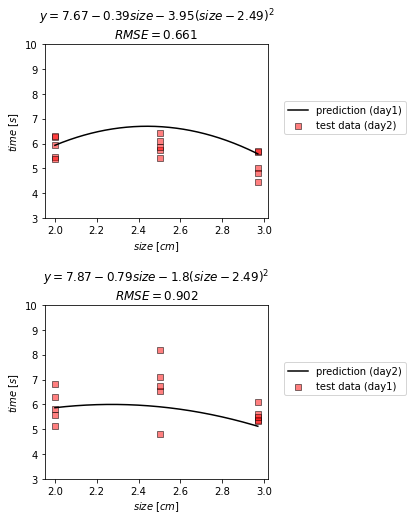

In [240]:
fig, ax = plt.subplots(2, 1, figsize=(4, 8))
plt.subplots_adjust(hspace=0.5)

for model, test, rmse, i in zip(*arg):
    
    ax[i].scatter(
        df.body_size[test.x.index], test.y,
        c="r", marker="s", edgecolor="k", alpha=0.5,
        label=f"test data (day{2-i})"
    )
    title = f"$y=" + f"{model.intercept_.round(2)}" + \
    "".join(
        [f"{model.coef_[idx].round(2)}{name}" for idx, name in enumerate(new_col)
        ]
    ) + "$\n" + "$RMSE=" + f"{rmse.round(3)}$"
    ax[i].plot(
        x_p, model.predict(x_2d), c="k",
        label=f"prediction (day{i+1})"
    )
    
    ax[i].set(title=title, ylabel="$time$ $[s]$", xlabel="$size$ $[cm]$")
    ax[i].set_ylim([3, 10])
    ax[i].legend(bbox_to_anchor=(1.05, 0.7))

if conf.savefile:
    plt.savefig(f"{conf.dirctory}/model{num_target}.png", **conf.kwarg_savefig)

- 5つめのモデル

In [241]:
num_target = 5
l_dim = [2, 3]

arg = [
    l_model[num_target],
    l_test[num_target],
    l_rmse[num_target],
    np.arange(2)
]

In [242]:
x_p = np.linspace(2, 2.97, 1000).reshape(-1, 1)
x_2d = x_pred(x_p, l_dim, (2+2.5+2.97)/3)
new_col = pretty_idx("size", l_dim, (2+2.5+2.97)/3)

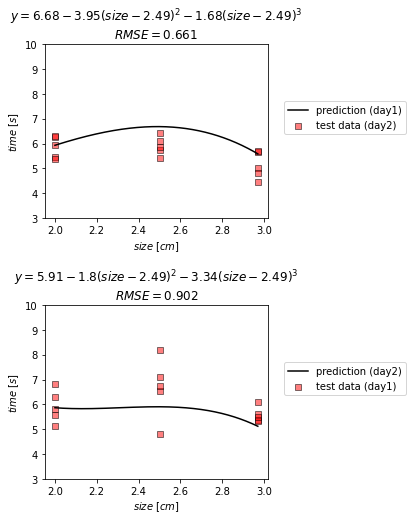

In [243]:
fig, ax = plt.subplots(2, 1, figsize=(4, 8))
plt.subplots_adjust(hspace=0.5)

for model, test, rmse, i in zip(*arg):
    
    ax[i].scatter(
        df.body_size[test.x.index], test.y,
        c="r", marker="s", edgecolor="k", alpha=0.5,
        label=f"test data (day{2-i})"
    )
    title = f"$y=" + f"{model.intercept_.round(2)}" + \
    "".join(
        [f"{model.coef_[idx].round(2)}{name}" for idx, name in enumerate(new_col)
        ]
    ) + "$\n" + "$RMSE=" + f"{rmse.round(3)}$"
    ax[i].plot(
        x_p, model.predict(x_2d), c="k",
        label=f"prediction (day{i+1})"
    )
    
    ax[i].set(title=title, ylabel="$time$ $[s]$", xlabel="$size$ $[cm]$")
    ax[i].set_ylim([3, 10])
    ax[i].legend(bbox_to_anchor=(1.05, 0.7))

if conf.savefile:
    plt.savefig(f"{conf.dirctory}/model{num_target}.png", **conf.kwarg_savefig)

- 6つめのモデル

In [244]:
num_target = 6
l_dim = [1, 2, 3]

arg = [
    l_model[num_target],
    l_test[num_target],
    l_rmse[num_target],
    np.arange(2)
]

In [245]:
x_p = np.linspace(2, 2.97, 1000).reshape(-1, 1)
x_2d = x_pred(x_p, l_dim, (2+2.5+2.97)/3)
new_col = pretty_idx("size", l_dim, (2+2.5+2.97)/3)

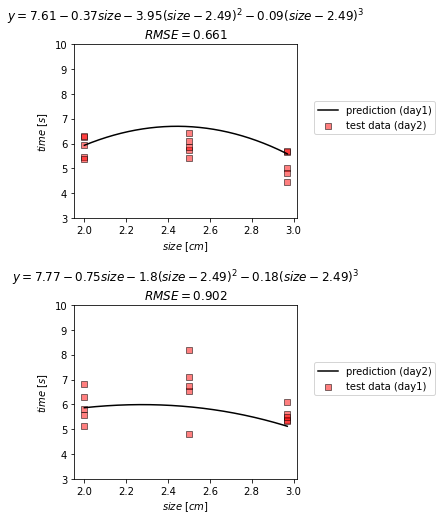

In [246]:
fig, ax = plt.subplots(2, 1, figsize=(4, 8))
plt.subplots_adjust(hspace=0.5)

for model, test, rmse, i in zip(*arg):
    
    ax[i].scatter(
        df.body_size[test.x.index], test.y,
        c="r", marker="s", edgecolor="k", alpha=0.5,
        label=f"test data (day{2-i})"
    )
    title = f"$y=" + f"{model.intercept_.round(2)}" + \
    "".join(
        [f"{model.coef_[idx].round(2)}{name}" for idx, name in enumerate(new_col)
        ]
    ) + "$\n" + "$RMSE=" + f"{rmse.round(3)}$"
    ax[i].plot(
        x_p, model.predict(x_2d), c="k",
        label=f"prediction (day{i+1})"
    )
    
    ax[i].set(title=title, ylabel="$time$ $[s]$", xlabel="$size$ $[cm]$")
    ax[i].set_ylim([3, 10])
    ax[i].legend(bbox_to_anchor=(1.05, 0.7))

if conf.savefile:
    plt.savefig(f"{conf.dirctory}/model{num_target}.png", **conf.kwarg_savefig)

- 予測の観点では、これらの3つのモデルが最良であったが、変数の数と解釈性のシンプルさ的には最初のやつが最良か？